### Modelo de regresión logística
- Importación de las dependencias

In [241]:
import pandas as pd
import joblib 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


### Leyendo el dataset y verificando su contenido

In [242]:
df=pd.read_csv("estado-animo.csv")
df.head(2)

,ID,Time,Age,HRV (ms),GSR (μS),EEG Power Bands,Blood Pressure (mmHg),Oxygen Saturation (%),Heart Rate (BPM),Ambient Noise (dB),Cognitive Load,Mood State,Psychological State,Respiration Rate (BPM),Skin Temp (°C),Focus Duration (s),Task Type,Gender
0,1,2024-01-01 00:00:00,22,3.303.973.885.213.790,1.031.805.777.942.350,"[0.7583653347946298, 1.423247998317594, 0.6157...",114/79,9.843.331.161.949.940,98,56.863.054.434.594,Low,Anxious,Stressed,21,3.456.648.362.706.430,27,Exam,Female
1,2,2024-01-01 00:00:01,23,49.914.651.237.079.800,13.409.828.672.616.600,"[0.5520419333516282, 1.858065835142619, 0.3766...",113/86,9.894.450.488.549.340,70,4.534.342.962.969.860,Low,Neutral,Stressed,21,3.535.859.349.215.910,282,Assignment,Male


### Traduciendo las columnas para una mejor comprensión

In [243]:
traduccion_estado_animo = {
    'ID': 'ID',
    'Time': 'Tiempo',
    'Age': 'Edad',
    'HRV (ms)': 'VFC_ms',
    'GSR (μS)': 'RGP_microS',
    'EEG Power Bands': 'Bandas_Poder_EEG',
    'Blood Pressure (mmHg)': 'Presion_Arterial_mmHg',
    'Oxygen Saturation (%)': 'Saturacion_Oxigeno_porcentaje',
    'Heart Rate (BPM)': 'Frecuencia_Cardiaca_BPM',
    'Ambient Noise (dB)': 'Ruido_Ambiental_dB',
    'Cognitive Load': 'Carga_Cognitiva',
    'Mood State': 'Estado_Animo',
    'Psychological State': 'Estado_Psicologico',
    'Respiration Rate (BPM)': 'Frecuencia_Respiratoria_BPM',
    'Skin Temp (°C)': 'Temperatura_Piel_Celsius',
    'Focus Duration (s)': 'Duracion_Enfoque_segundos',
    'Task Type': 'Tipo_Tarea',
    'Gender': 'Genero'
}

df_renombrado_animo = df.rename(columns=traduccion_estado_animo)
df_renombrado_animo.head(2)

,ID,Tiempo,Edad,VFC_ms,RGP_microS,Bandas_Poder_EEG,Presion_Arterial_mmHg,Saturacion_Oxigeno_porcentaje,Frecuencia_Cardiaca_BPM,Ruido_Ambiental_dB,Carga_Cognitiva,Estado_Animo,Estado_Psicologico,Frecuencia_Respiratoria_BPM,Temperatura_Piel_Celsius,Duracion_Enfoque_segundos,Tipo_Tarea,Genero
0,1,2024-01-01 00:00:00,22,3.303.973.885.213.790,1.031.805.777.942.350,"[0.7583653347946298, 1.423247998317594, 0.6157...",114/79,9.843.331.161.949.940,98,56.863.054.434.594,Low,Anxious,Stressed,21,3.456.648.362.706.430,27,Exam,Female
1,2,2024-01-01 00:00:01,23,49.914.651.237.079.800,13.409.828.672.616.600,"[0.5520419333516282, 1.858065835142619, 0.3766...",113/86,9.894.450.488.549.340,70,4.534.342.962.969.860,Low,Neutral,Stressed,21,3.535.859.349.215.910,282,Assignment,Male


### Separando la presión sistólica de la diastólica para utilizarlos como datos de entrenamiento

In [244]:
df_renombrado_animo[['presion_sistolica', 'presion_diastolica']] = df_renombrado_animo['Presion_Arterial_mmHg'].str.split('/', expand=True).astype(int)
df_renombrado_animo.head(2)



,ID,Tiempo,Edad,VFC_ms,RGP_microS,Bandas_Poder_EEG,Presion_Arterial_mmHg,Saturacion_Oxigeno_porcentaje,Frecuencia_Cardiaca_BPM,Ruido_Ambiental_dB,Carga_Cognitiva,Estado_Animo,Estado_Psicologico,Frecuencia_Respiratoria_BPM,Temperatura_Piel_Celsius,Duracion_Enfoque_segundos,Tipo_Tarea,Genero,presion_sistolica,presion_diastolica
0,1,2024-01-01 00:00:00,22,3.303.973.885.213.790,1.031.805.777.942.350,"[0.7583653347946298, 1.423247998317594, 0.6157...",114/79,9.843.331.161.949.940,98,56.863.054.434.594,Low,Anxious,Stressed,21,3.456.648.362.706.430,27,Exam,Female,114,79
1,2,2024-01-01 00:00:01,23,49.914.651.237.079.800,13.409.828.672.616.600,"[0.5520419333516282, 1.858065835142619, 0.3766...",113/86,9.894.450.488.549.340,70,4.534.342.962.969.860,Low,Neutral,Stressed,21,3.535.859.349.215.910,282,Assignment,Male,113,86


### Renombrando valores string a tipos numéricos para nuestros datos de entrenamiento

In [245]:
df_renombrado_animo["label"]=df_renombrado_animo["Estado_Psicologico"].map({"Stressed":1, "Relaxed":0, "Focused":2, "Anxious":3}).astype(int)
df_renombrado_animo["Genero"]=df_renombrado_animo["Genero"].map({"Male":1, "Female":0, "Other":2} )

### Verificando la cantidad de estados psicológicos que utilizaremos como resultado de las predicciones
- En este caso nos encontramos con 4 posibles resultados y sus cantidades de datos de entrenamiento

In [246]:
df_renombrado_animo["Estado_Psicologico"].value_counts()

Estado_Psicologico
Stressed    263
Focused     249
Relaxed     247
Anxious     241
Name: count, dtype: int64

### Verificando que todo esté correcto

In [247]:
df_renombrado_animo.head(2)

,ID,Tiempo,Edad,VFC_ms,RGP_microS,Bandas_Poder_EEG,Presion_Arterial_mmHg,Saturacion_Oxigeno_porcentaje,Frecuencia_Cardiaca_BPM,Ruido_Ambiental_dB,...,Estado_Animo,Estado_Psicologico,Frecuencia_Respiratoria_BPM,Temperatura_Piel_Celsius,Duracion_Enfoque_segundos,Tipo_Tarea,Genero,presion_sistolica,presion_diastolica,label
0,1,2024-01-01 00:00:00,22,3.303.973.885.213.790,1.031.805.777.942.350,"[0.7583653347946298, 1.423247998317594, 0.6157...",114/79,9.843.331.161.949.940,98,56.863.054.434.594,...,Anxious,Stressed,21,3.456.648.362.706.430,27,Exam,0,114,79,1
1,2,2024-01-01 00:00:01,23,49.914.651.237.079.800,13.409.828.672.616.600,"[0.5520419333516282, 1.858065835142619, 0.3766...",113/86,9.894.450.488.549.340,70,4.534.342.962.969.860,...,Neutral,Stressed,21,3.535.859.349.215.910,282,Assignment,1,113,86,1


### Separando los datos que utilizaremos para entrenar el modelo

In [248]:


x_train = df_renombrado_animo[["Edad","presion_sistolica", "presion_diastolica", "Frecuencia_Cardiaca_BPM", "Duracion_Enfoque_segundos", "Genero"]]
y_train = df_renombrado_animo["label"]


### Creando el modelo y entrenandolo con los datos seleccionados

In [249]:
model = LogisticRegression(max_iter=5000)
model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [250]:
accuracy = model.score(x_train, y_train)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.30


### Haciendo una predicción y verificado la predicción el estado psicológico obtenido

In [251]:
prediccion=model.predict([[22,114, 79, 98, 27, 0]])
if prediccion==0:
        print("Estás relajado")
elif prediccion==1:
        print("Estás estresado")
elif prediccion==2:
        print("Estás enfocado")
elif prediccion==3:
        print("Estás ansioso")

Estás ansioso


c:\Users\marcelo\Desktop\tlp3-Tp-Final\Backend\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


La imagen muestra la matriz de confusión del modelo de clasificación para predecir el estado psicológico. Cada fila representa la clase real (verdadera) y cada columna la clase predicha por el modelo.

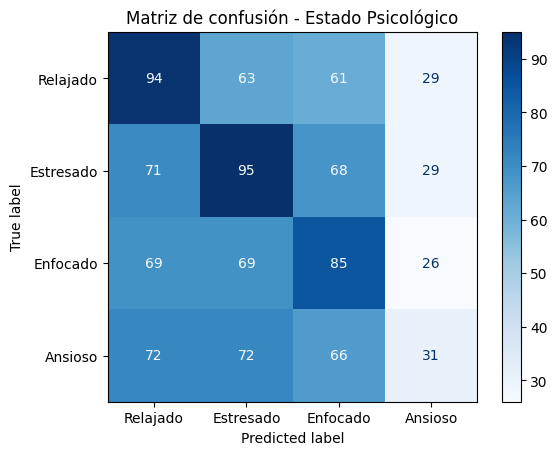

In [252]:

y_pred = model.predict(x_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Relajado", "Estresado", "Enfocado", "Ansioso"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión - Estado Psicológico")
plt.show()

### Exportando el modelo

In [253]:
joblib.dump(model, "modelo_estado_psicologico.pkl")

['modelo_estado_psicologico.pkl']

### Probando el modelo

In [254]:
prueba = joblib.load("modelo_estado_psicologico.pkl")
prediccion_prueba = prueba.predict([[22,114, 79, 98, 27, 0]])
if prediccion_prueba==0:
        print("Estás relajado")
elif prediccion_prueba==1:
        print("Estás estresado")
elif prediccion_prueba==2:
        print("Estás enfocado")
elif prediccion_prueba==3:
        print("Estás ansioso")

Estás ansioso


c:\Users\marcelo\Desktop\tlp3-Tp-Final\Backend\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
